In [1]:
# !pip install pandas numpy scikit-learn seaborn matplotlib missingno nltk imbalanced-learn

In [2]:
# import sys
# import seaborn as sns
# print('Python ver -', sys.version)
# print('seaborn ver -', sns.__version__)

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from scipy.stats import shapiro, anderson
from sklearn.preprocessing import power_transform
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as misno
import re
import string
# from imblearn.over_sampling import SMOTE

# Import NLTK(Natural Language Toolkit) for text processing
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
data = pd.read_csv("Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

#### Data Preprocessing

In [5]:
data = pd.read_csv("Dataset.csv")

columns_to_drop = ['Chief_complain', 'Diagnosis in ED','Error_group', 'KTAS duration_min', 'mistriage','Group','Patients number per hour','Length of stay_min']
data.drop(columns=columns_to_drop, inplace=True)

data = data.rename(columns={'Disposition':'hospitalized','Arrival mode':'arrivalmode','NRS_pain':'painrating'})
data.columns = [col.lower() for col in data.columns]

data['hospitalized'] = data['hospitalized'].replace({1:0, 2:1, 3:1, 4:0,5:1,6:0,7:1})
data['mental'] = data['mental'].replace({2:1, 3:0, 4:0})
data['sex'] = data['sex'].replace({1:0,2:1})
data['injury'] = data['injury'].replace({1:0,2:1})
data = data[[col for col in data.columns if col != 'hospitalized'] + ['hospitalized']]
data.head()

,sex,age,arrivalmode,injury,mental,pain,painrating,sbp,dbp,hr,rr,bt,saturation,ktas_rn,ktas_expert,hospitalized
0,1,71,3,1,1,1,2,160,100,84,18,36.6,100,2,4,0
1,0,56,3,1,1,1,2,137,75,60,20,36.5,NaN,4,5,0
2,0,68,2,1,1,1,2,130,80,102,20,36.6,98,4,5,1
3,1,71,1,0,1,1,3,139,94,88,20,36.5,NaN,4,5,0
4,1,58,3,0,1,1,3,91,67,93,18,36.5,NaN,4,5,0


In [6]:
arrival_mode_mapping = {
    1: 'Walking',
    2: 'Emergency Services',
    3: 'Private Car',
    4: 'Private Ambulance',
    5: 'Public Transportation',
    6: 'Wheelchair',
    7: 'Others'
}

data['arrivalmode'] = data['arrivalmode'].map(arrival_mode_mapping)

In [7]:
# List of columns to clean and convert
columns_to_clean = ['painrating', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation']
for column in columns_to_clean:
    data[column] = data[column].replace({'#BOŞ!': np.NaN, '??': np.NaN}).astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           1267 non-null   int64  
 1   age           1267 non-null   int64  
 2   arrivalmode   1267 non-null   object 
 3   injury        1267 non-null   int64  
 4   mental        1267 non-null   int64  
 5   pain          1267 non-null   int64  
 6   painrating    711 non-null    float64
 7   sbp           1242 non-null   float64
 8   dbp           1238 non-null   float64
 9   hr            1247 non-null   float64
 10  rr            1245 non-null   float64
 11  bt            1249 non-null   float64
 12  saturation    570 non-null    float64
 13  ktas_rn       1267 non-null   int64  
 14  ktas_expert   1267 non-null   int64  
 15  hospitalized  1267 non-null   int64  
dtypes: float64(7), int64(8), object(1)
memory usage: 158.5+ KB


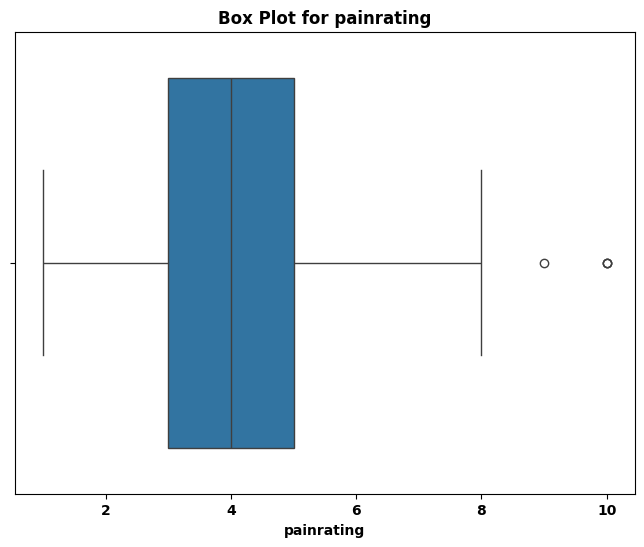

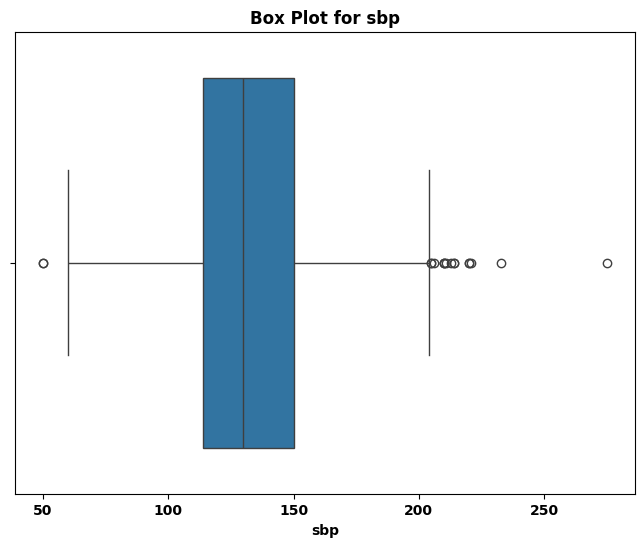

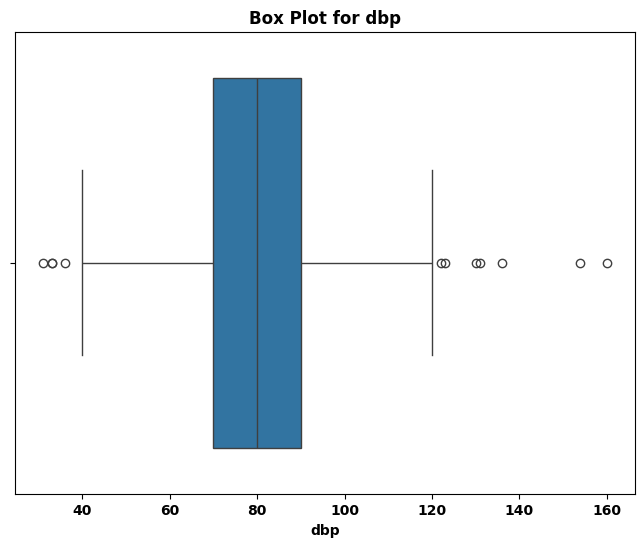

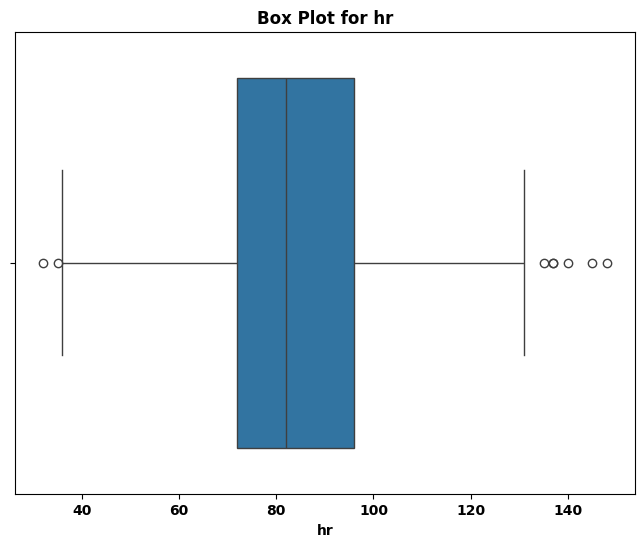

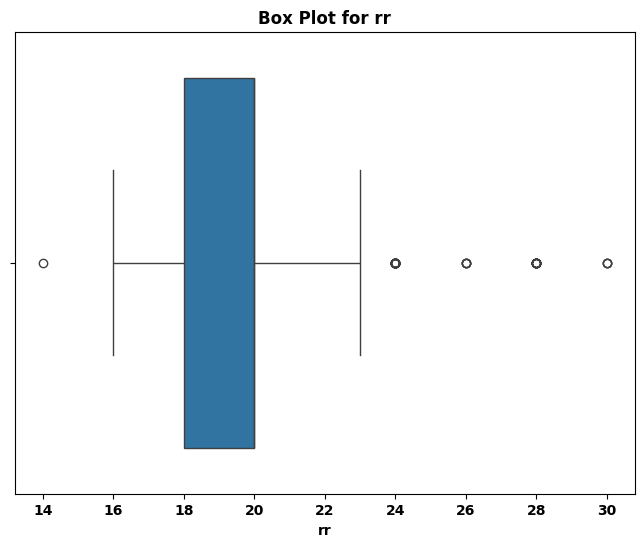

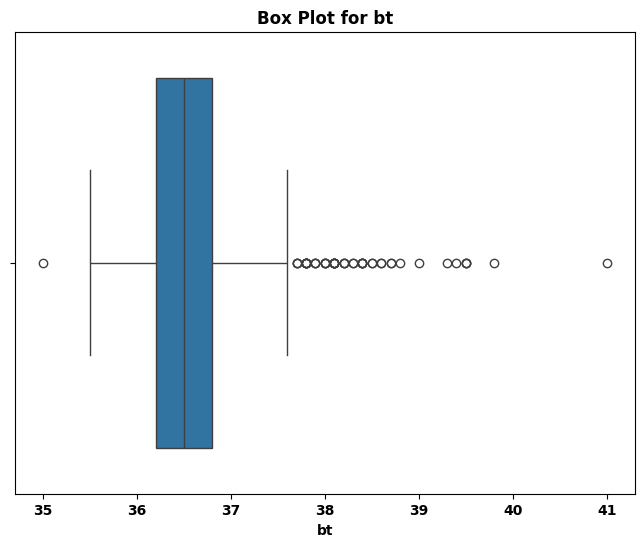

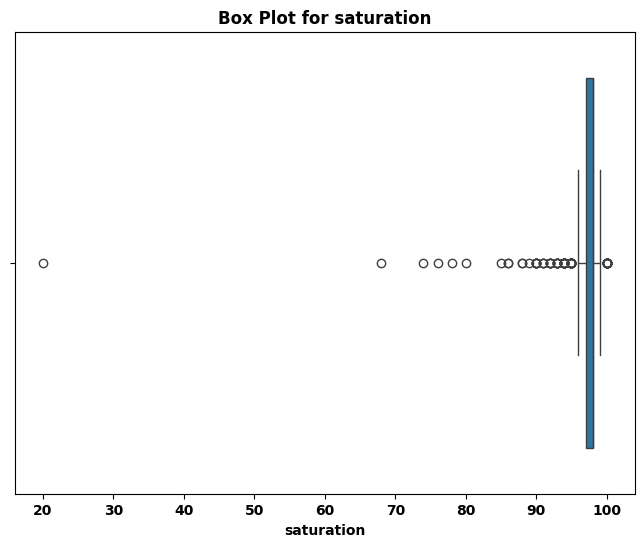

In [8]:
for column in columns_to_clean:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

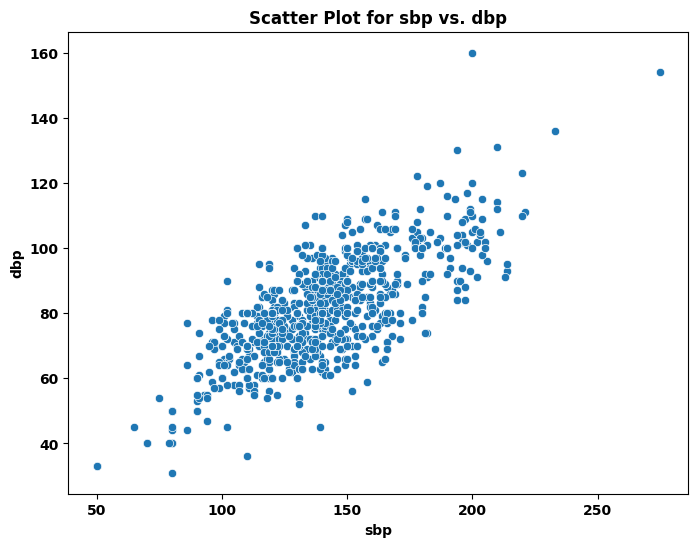

In [9]:
# Assuming 'sbp' and 'dbp' are related
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sbp', y='dbp', data=data)
plt.title('Scatter Plot for sbp vs. dbp')
plt.show()

            n_miss  ratio
saturation     697  55.01
painrating     556  43.88
dbp             29   2.29
sbp             25   1.97
rr              22   1.74
hr              20   1.58
bt              18   1.42


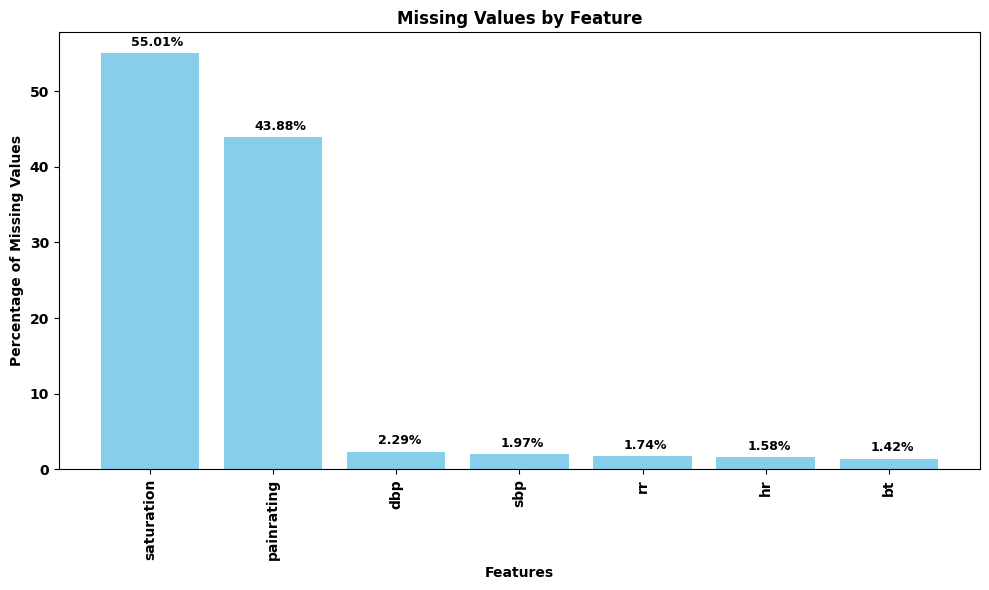

In [10]:
def missingValues(data):
    variables_NA = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[variables_NA].isnull().sum().sort_values(ascending=False)
    ratio = (data[variables_NA].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_data = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    return missing_data

missing_data = missingValues(data)

# def columns_with_null_values(data):
#     columns_with_na = data.columns[data.isnull().any()].tolist()
#     return columns_with_na
# columns_with_null = columns_with_null_values(data)
# print(columns_with_null)

print(missing_data)
    
# Create a bar plot for missing values
plt.figure(figsize=(10, 6))
bars = plt.bar(missing_data.index, missing_data['ratio'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values by Feature')
plt.xticks(rotation=90)

# Annotate the bars with 'n_miss' and 'ratio' values
for bar, n_miss, ratio in zip(bars, missing_data['n_miss'], missing_data['ratio']):
        plt.text(bar.get_x() + bar.get_width() / 2-0.15, bar.get_height() + 1, f'{ratio}%', fontsize=9, color='black')

plt.tight_layout()
plt.show()

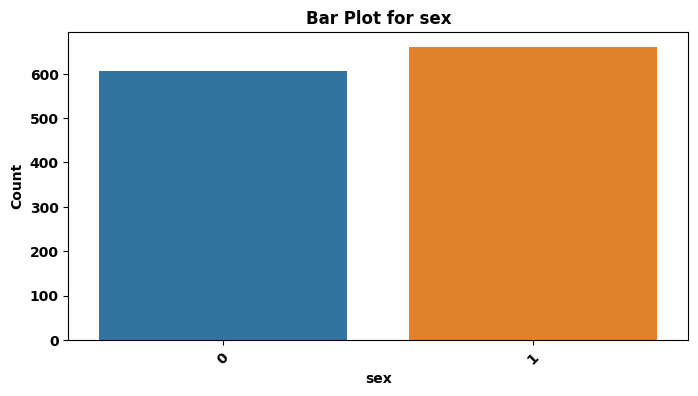

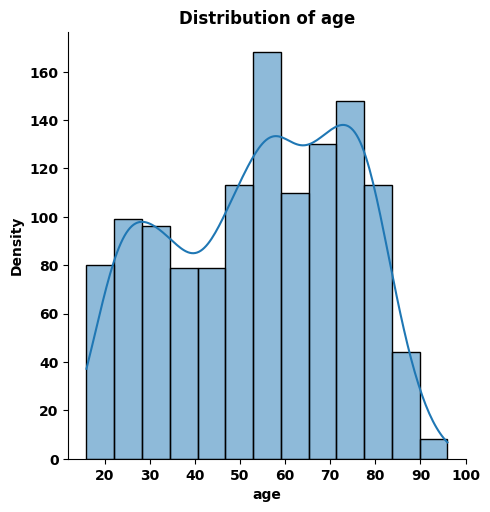

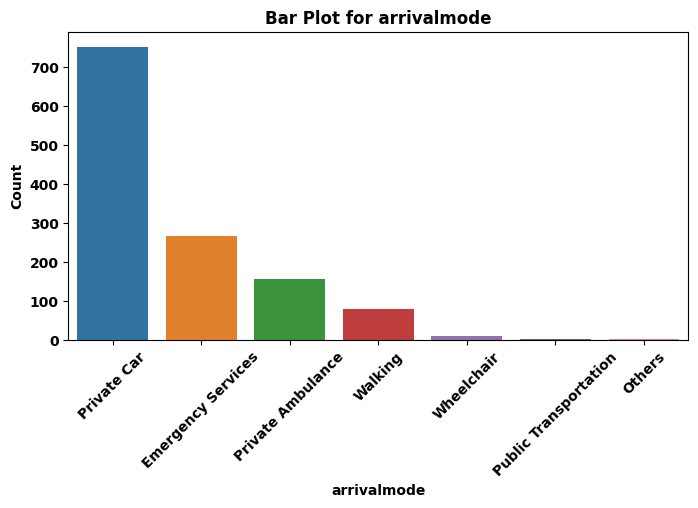

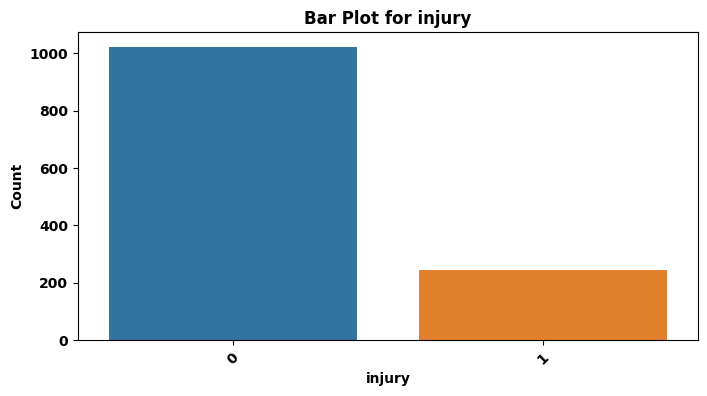

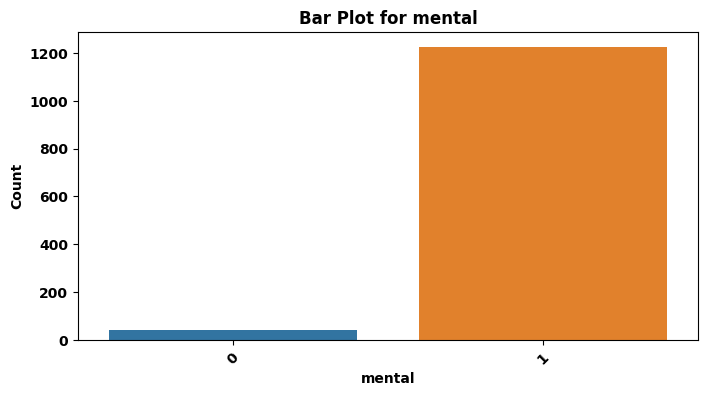

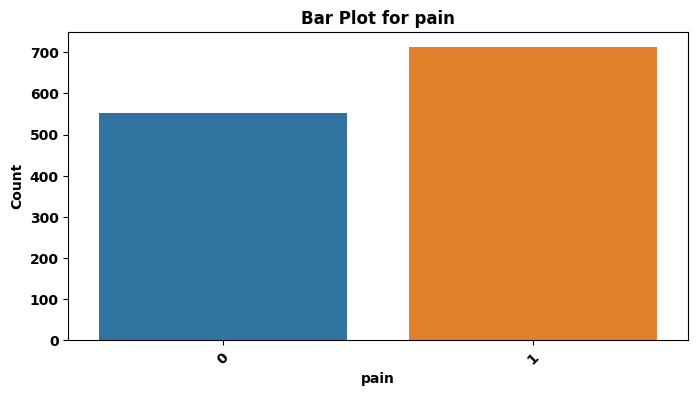

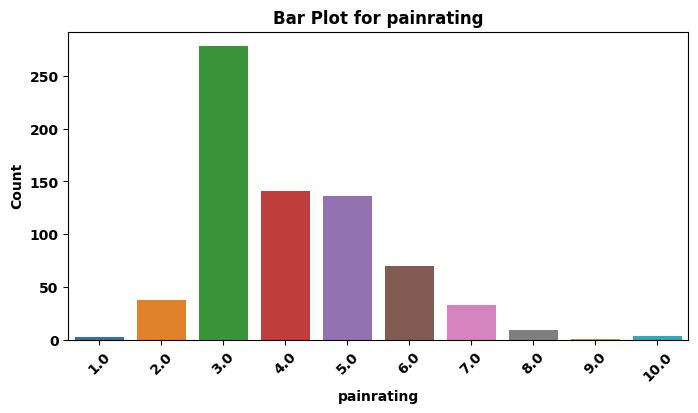

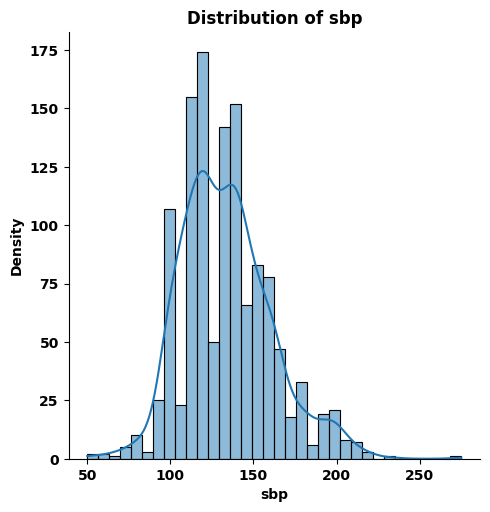

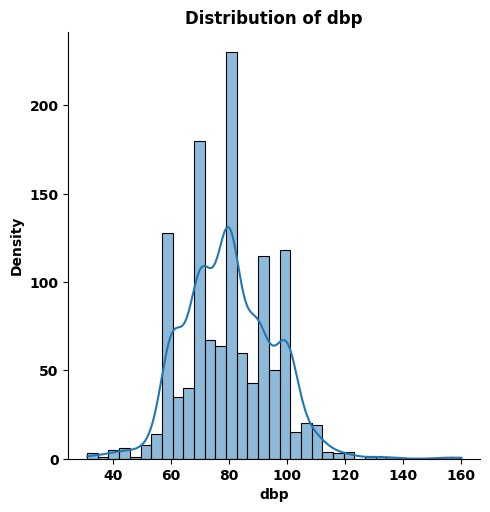

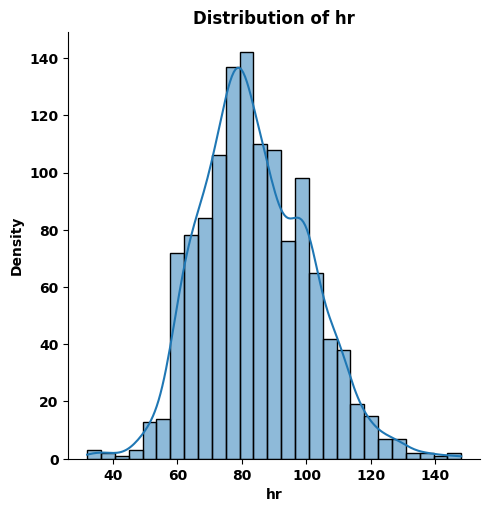

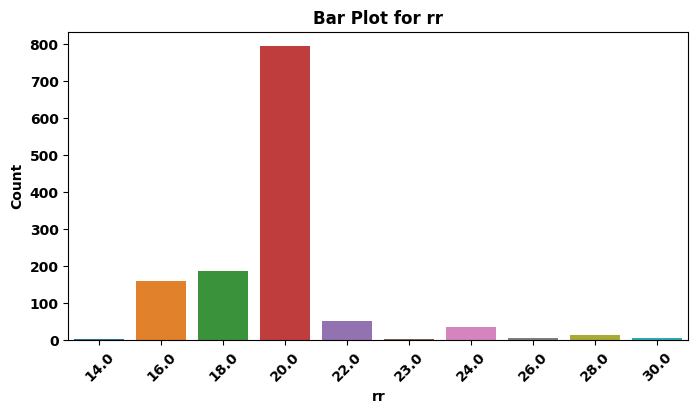

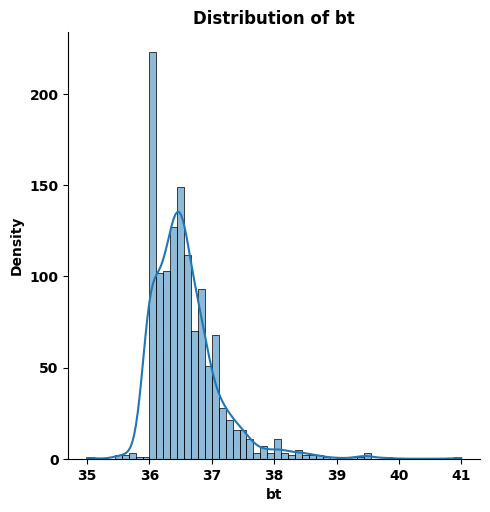

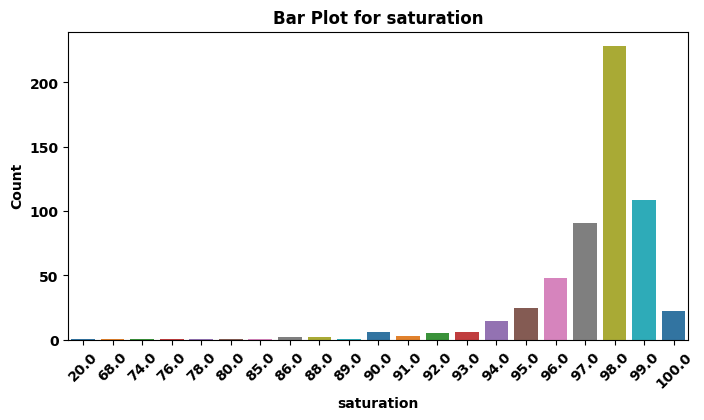

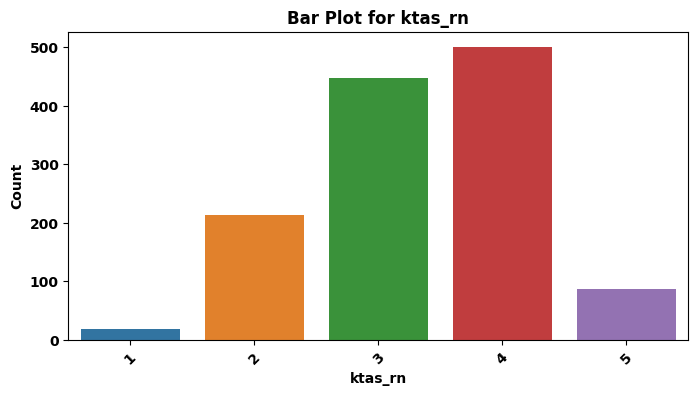

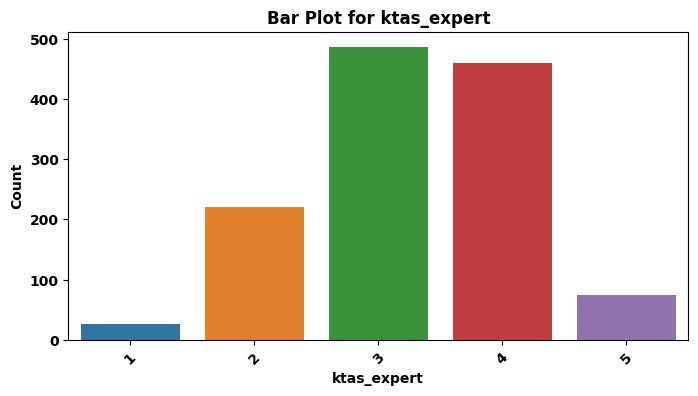

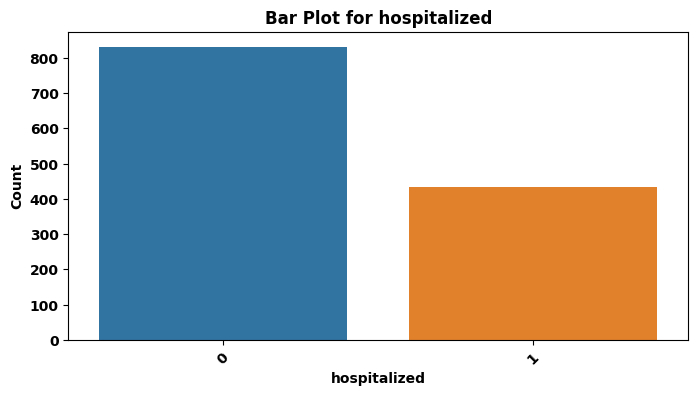

In [11]:
continuous_columns =["age", "hr","sbp","dbp","bt"]
for column in data.columns:
    if column in continuous_columns :
        sns.displot(data[column], kde=True) 
        # Additional plot customization if needed
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')

        # Show the plot
        plt.show()
        
    # Check if the column is non-numeric (categorical or discrete)
    elif data[column].dtype in ["object", "int64", "float64"]:
        # Count the occurrences of each unique value in the column
        value_counts = data[column].value_counts()

        # Create a bar plot
        plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
        sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette="tab10", legend=False)
        plt.title(f'Bar Plot for {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

        # Show the plot
        plt.show()

In [12]:
# # Specify the columns you want to plot
# columns_to_plot = data.columns

# # Set the number of columns per row
# columns_per_row = 2

# # Calculate the number of rows needed
# num_rows = (len(columns_to_plot) // columns_per_row) + 1

# # Create subplots
# fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(15, num_rows * 3))

# # Flatten the axis array to make indexing easier
# ax = ax.flatten()

# # Loop through columns and create subplots
# for i, column in enumerate(columns_to_plot):
#     sns.countplot(x=column, data=data, ax=ax[i])
#     ax[i].set_title(f'Count Plot for {column}')
#     ax[i].set_ylabel('Count')

# # Adjust layout
# plt.tight_layout()
# plt.show()

<Axes: >

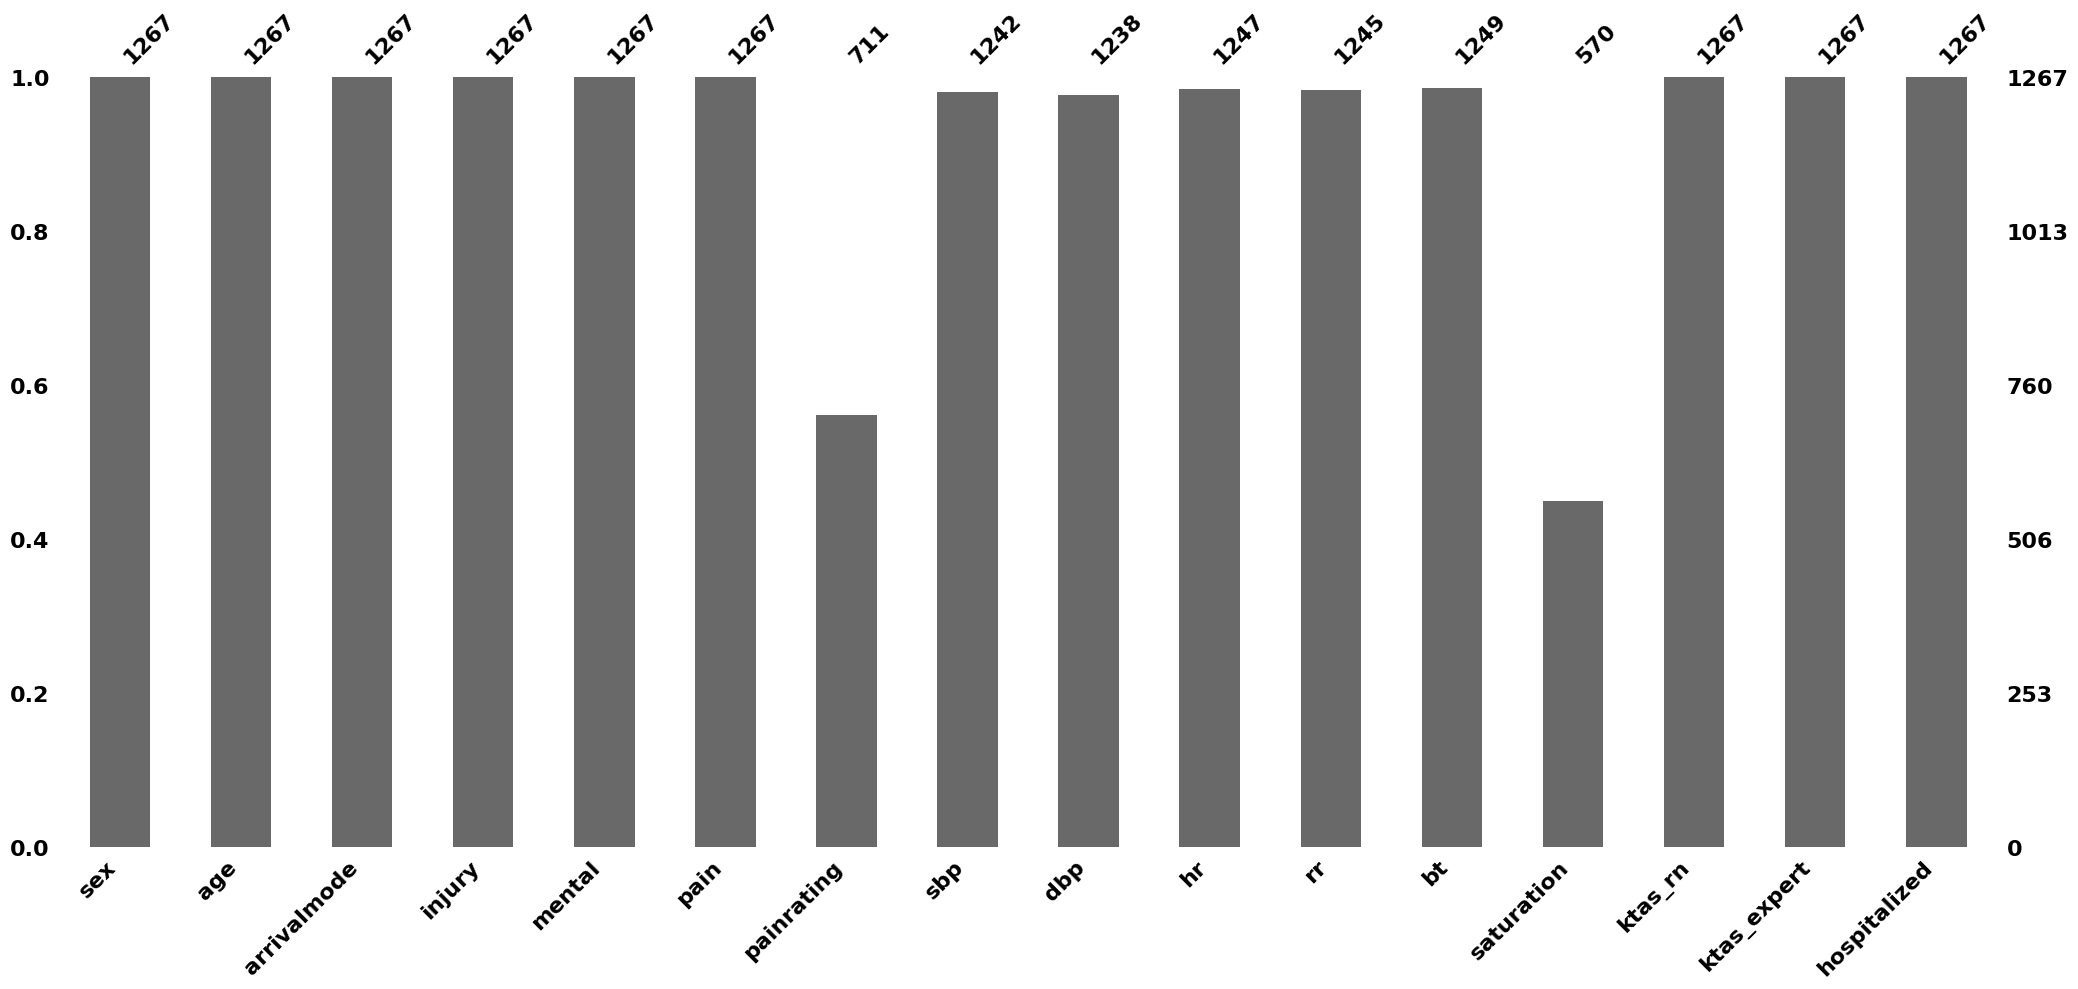

In [13]:
misno.bar(data)

In [14]:
# data.isnull().values.any()

In [15]:
# sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [16]:
# sns.boxplot(x=data['saturation'])
# plt.show()

In [17]:
# correlation_matrix = data.corr(method='pearson')
# plt.figure(figsize=(20, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Correlation Matrix')
# plt.show()

#### Handling Null values

In [18]:
def impute_nan(df,variable,method):   
    if method=="random":
        df[variable+"_random"]=df[variable]
        ##It will have the random sample to fill the na
        random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
        ##pandas need to have same index in order to merge the dataset
        random_sample.index=df[df[variable].isnull()].index
        df.loc[df[variable].isnull(),variable+'_random']=random_sample
        
    elif method=="median":
        data[variable] = data[variable].fillna(data[variable].median())
        
    elif method=="mean":
        data[variable] = data[variable].fillna(data[variable].mean())
        
        

In [19]:
# data_imputation =["painrating","rr","hr","sbp","dbp","bt"]
data_imputation =["rr","sbp","dbp","bt"]

for i in data_imputation:
    # impute_nan(data,i,"random")
    impute_nan(data,i,"median")
    
data['painrating']=data['painrating'].fillna(0)
impute_nan(data,'hr',"mean")


In [20]:
# data.drop(columns=data_imputation, inplace=True)
data.drop(columns='saturation', inplace=True)

In [21]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# data['painrating'].plot(kind='kde', ax=ax)
# # data.painrating_median.plot(kind='kde', ax=ax, color='red')
# data.painrating_random.plot(kind='kde', ax=ax, color='green')
# lines, labels = ax.get_legend_handles_labels()
# ax.legend(lines, labels, loc='best')

In [22]:
# for column in data.columns:
#     # Check if the column is non-numeric (categorical or discrete)
#     if data[column].dtype == "object" or data[column].dtype == "int64":
#         # Count the occurrences of each unique value in the column
#         value_counts = data[column].value_counts()

#         # Create a bar plot
#         plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
#         sns.barplot(x=value_counts.index, y=value_counts.values)
#         plt.title(f'Bar Plot for {column}')
#         plt.xlabel(column)
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

#         # Show the plot
#         plt.show()

In [23]:
data.isnull().values.any()

False

In [24]:
# misno.bar(data)

In [25]:
count = data['hospitalized'].value_counts()
print(count)

hospitalized
0    832
1    435
Name: count, dtype: int64


#### Feature Engineering

In [26]:
# def norm_test(feature):
#     print(feature)
#     # Original data
#     print('Shapiro: {}'.format(shapiro(data[feature])))
#     print('Anderson: {}'.format(anderson(data[feature])))

#     # Log-transformed data
#     log_transformed_data = np.log(data[feature])
#     print('Shapiro Log: {}'.format(shapiro(log_transformed_data)))

#     # Box-Cox transformed data
#     box_cox_transformed_data = power_transform(np.array(data[feature]).reshape(-1, 1), method='box-cox')
#     print('Shapiro Box: {}'.format(shapiro(box_cox_transformed_data)))

#     # Plot original and transformed distributions
#     plt.figure(figsize=(12, 6))
#     sns.distplot(data[feature], label='Original Data')
#     sns.distplot(log_transformed_data, label='Log-Transformed Data')
#     sns.distplot(box_cox_transformed_data, label='Box-Cox Transformed Data')
#     plt.legend()
#     plt.show()

# for column in data.columns:
#     try:
#         norm_test(column)
#     except ValueError as e:
#         print('error')

In [27]:
age_bins = [0, 18, 35, 50, 100]
hr_bins = [0, 60, 100, 200]   
rr_bins = [0, 12, 20, 100]     
sbp_bins = [0, 90, 120, 500]   
dbp_bins = [0, 60, 80, 200]   
bt_bins = [0, 36.1, 37.2, 200] 
pain_bins = [0, 3, 6, 9, 10]  

age_labels = ['Child', 'Young Adult', 'Adult', 'Senior']
labels = ['Low', 'Normal', 'High']
pain_labels = ['Low', 'Moderate', 'High', 'Severe']

data['pain_category'] = pd.cut(data['painrating'], bins=pain_bins, labels=pain_labels, include_lowest=True, right=False)
data['age_category'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)
data['hr_category'] = pd.cut(data['hr'], bins=hr_bins, labels=labels, right=False)
data['rr_category'] = pd.cut(data['rr'], bins=rr_bins, labels=labels, right=False)
data['sbp_category'] = pd.cut(data['sbp'], bins=sbp_bins, labels=labels, right=False)
data['dbp_category'] = pd.cut(data['dbp'], bins=dbp_bins, labels=labels, right=False)
data['bt_category'] = pd.cut(data['bt'], bins=bt_bins, labels=labels, right=False)



In [28]:
data.head()

,sex,age,arrivalmode,injury,mental,pain,painrating,sbp,dbp,hr,...,ktas_rn,ktas_expert,hospitalized,pain_category,age_category,hr_category,rr_category,sbp_category,dbp_category,bt_category
0,1,71,Private Car,1,1,1,2.0,160.0,100.0,84.0,...,2,4,0,Low,Senior,Normal,Normal,High,High,Normal
1,0,56,Private Car,1,1,1,2.0,137.0,75.0,60.0,...,4,5,0,Low,Senior,Normal,High,High,Normal,Normal
2,0,68,Emergency Services,1,1,1,2.0,130.0,80.0,102.0,...,4,5,1,Low,Senior,High,High,High,High,Normal
3,1,71,Walking,0,1,1,3.0,139.0,94.0,88.0,...,4,5,0,Moderate,Senior,Normal,High,High,High,Normal
4,1,58,Private Car,0,1,1,3.0,91.0,67.0,93.0,...,4,5,0,Moderate,Senior,Normal,Normal,Normal,Normal,Normal


In [29]:
data.isnull().values.any()

True

In [30]:
# continuous_columns =["age", "hr","sbp","dbp","bt"]
# for column in data.columns:
#     if column in continuous_columns :
#         sns.displot(data[column], kde=True) 
#         # Additional plot customization if needed
#         plt.title(f'Distribution of {column}')
#         plt.xlabel(column)
#         plt.ylabel('Density')

#         # Show the plot
#         plt.show()
        
#     # Check if the column is non-numeric (categorical or discrete)
#     # elif data[column].dtype in ["object", "int64", "float64"]:
#     else:
#         # Count the occurrences of each unique value in the column
#         value_counts = data[column].value_counts()

#         # Create a bar plot
#         plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
#         sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette="tab10", legend=False)
#         plt.title(f'Bar Plot for {column}')
#         plt.xlabel(column)
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

#         # Show the plot
#         plt.show()

In [31]:
data.columns

Index(['sex', 'age', 'arrivalmode', 'injury', 'mental', 'pain', 'painrating',
       'sbp', 'dbp', 'hr', 'rr', 'bt', 'ktas_rn', 'ktas_expert',
       'hospitalized', 'pain_category', 'age_category', 'hr_category',
       'rr_category', 'sbp_category', 'dbp_category', 'bt_category'],
      dtype='object')

In [32]:
columns_to_encode = ['arrivalmode', 'pain_category', 'age_category', 'hr_category', 'rr_category', 'sbp_category', 'dbp_category', 'bt_category', 'mental']


data_encoded = pd.get_dummies(data[columns_to_encode], drop_first=True, dtype=int)
data_encoded.head()

,mental,arrivalmode_Others,arrivalmode_Private Ambulance,arrivalmode_Private Car,arrivalmode_Public Transportation,arrivalmode_Walking,arrivalmode_Wheelchair,pain_category_Moderate,pain_category_High,pain_category_Severe,...,hr_category_Normal,hr_category_High,rr_category_Normal,rr_category_High,sbp_category_Normal,sbp_category_High,dbp_category_Normal,dbp_category_High,bt_category_Normal,bt_category_High
0,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,1,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,1,1,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,1,0
3,1,0,0,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,1,1,0
4,1,0,0,1,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0


In [33]:
data_encoded.columns

Index(['mental', 'arrivalmode_Others', 'arrivalmode_Private Ambulance',
       'arrivalmode_Private Car', 'arrivalmode_Public Transportation',
       'arrivalmode_Walking', 'arrivalmode_Wheelchair',
       'pain_category_Moderate', 'pain_category_High', 'pain_category_Severe',
       'age_category_Young Adult', 'age_category_Adult', 'age_category_Senior',
       'hr_category_Normal', 'hr_category_High', 'rr_category_Normal',
       'rr_category_High', 'sbp_category_Normal', 'sbp_category_High',
       'dbp_category_Normal', 'dbp_category_High', 'bt_category_Normal',
       'bt_category_High'],
      dtype='object')

In [34]:

additional_features = ['sex','ktas_expert', 'injury', 'pain', 'hospitalized']
data= pd.concat([data_encoded,data[additional_features]], axis=1)
data.head()

,mental,arrivalmode_Others,arrivalmode_Private Ambulance,arrivalmode_Private Car,arrivalmode_Public Transportation,arrivalmode_Walking,arrivalmode_Wheelchair,pain_category_Moderate,pain_category_High,pain_category_Severe,...,sbp_category_High,dbp_category_Normal,dbp_category_High,bt_category_Normal,bt_category_High,sex,ktas_expert,injury,pain,hospitalized
0,1,0,0,1,0,0,0,0,0,0,...,1,0,1,1,0,1,4,1,1,0
1,1,0,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,5,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,5,1,1,1
3,1,0,0,0,0,1,0,1,0,0,...,1,0,1,1,0,1,5,0,1,0
4,1,0,0,1,0,0,0,1,0,0,...,0,1,0,1,0,1,5,0,1,0


In [35]:
missing_data = missingValues(data)

print(missing_data)


Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [36]:
data.to_csv('processedData.csv', sep=',', index=False, encoding='utf-8')

#### Model Training 

In [37]:
from imblearn.over_sampling import SMOTE

In [38]:
X = data.drop('hospitalized', axis=1)
y = data[['hospitalized']]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy='auto',  random_state=15)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



# Naive Bayes model
# NB = GaussianNB().fit(X_resampled, y_resampled)

NB = GaussianNB(priors=[0.5, 0.5]).fit(X_resampled, y_resampled)
multinomialNB = MultinomialNB().fit(X_resampled, y_resampled)


# Support Vector Machine model
svm = SVC(random_state=357, gamma='auto').fit(X_resampled, y_resampled)

# Random Forest model (added for diversity)
rf = RandomForestClassifier(random_state=42, n_estimators=100).fit(X_resampled, y_resampled)

models = [
    ("Naive Bayes", NB),
    ("Support Vector Machine", svm),
    ("Random Forest", rf),
    ("MultinomialNB", multinomialNB)
]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)
    
    
    

# smote = SMOTE(sampling_strategy='auto')
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 72)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 62)



# NB = GaussianNB().fit(X_train, y_train)


# svm = SVC(random_state=357,gamma='auto').fit(X_train, y_train)






C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

Naive Bayes: (0.385827)
Support Vector Machine: (0.783465)
Random Forest: (0.775591)
MultinomialNB: (0.744094)


##### 55 is the best random state

In [42]:
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
import logging
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore", message="DataConversionWarning")
warnings.filterwarnings("ignore", category=DataConversionWarning)
logging.basicConfig(level=logging.INFO, format='%(message)s')

# ... (rest of your code)

# Define the models inside the loop
models = [
    ("Support Vector Machine", SVC(gamma='auto')),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("MultinomialNB", MultinomialNB())
]

# Define the hyperparameter ranges for Randomized Search
param_dist = {
    'smote__random_state': range(100),
    'classifier__SVC__random_state': range(100),
    'classifier__RandomForestClassifier__random_state': range(100),
}

# Number of random search iterations
n_iter_search = 10  # Adjust as needed

def run_experiment(i, j, k, l, use_randomized_search=False):
    logging.info(f"SMOTE: {i}, Data Split: {j}, SVM Random State: {k}, RF Random State: {l}")
    X = data.drop('hospitalized', axis=1)
    y = data[['hospitalized']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=j)

    # Apply SMOTE for oversampling
    smote = SMOTE(sampling_strategy='auto', random_state=i)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Use Randomized Search if specified
    if use_randomized_search:
        pipeline = Pipeline([
            ('smote', SMOTE(sampling_strategy='auto')),
            ('classifier', SVC(gamma='auto'))  # You can replace this with RandomForestClassifier or other classifiers
        ])

        # Perform Randomized Search with cross-validation
        random_search = RandomizedSearchCV(
            pipeline, param_distributions=param_dist, n_iter=n_iter_search, scoring='accuracy', n_jobs=-1, cv=5
        )
        random_search.fit(X_resampled, y_resampled)

        # Get the best parameters
        best_params = random_search.best_params_
        
        # Use the best parameters in your final model
        model = random_search.best_estimator_.named_steps['classifier']
        model.fit(X_resampled, y_resampled)
    else:
        maxacc = 0

        for name, model in models:
            if name == "Support Vector Machine":
                model.set_params(random_state=k)
            elif name == "Random Forest":
                model.set_params(random_state=l)

            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            maxacc += acc * 100

        maxacc /= 3
        return maxacc, i, j, k, l

# Iterate over hyperparameter values using Randomized Search
random_search_results = Parallel(n_jobs=-1)(delayed(lambda i, j, k, l: run_experiment(i, j, k, l, use_randomized_search=True))(i, j, k, l) for i in range(10) for j in range(10) for k in range(10) for l in range(10))

# ... (rest of your code)




ValueError: Invalid parameter 'SVC' for estimator SVC(gamma='auto'). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

In [39]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
import logging

warnings.filterwarnings("ignore", message="DataConversionWarning")
logging.basicConfig(level=logging.INFO, format='%(message)s')

num_runs = 100  # Adjust as needed
maxvalu = 0
splitran = 0
smoteran = 0
svm_random_state = 0
rf_random_state = 0

# Define the models outside the loop
models = [
    ("Support Vector Machine", SVC(random_state=357, gamma='auto')),
    ("Random Forest", RandomForestClassifier(random_state=42, n_estimators=100)),
    ("MultinomialNB", MultinomialNB())
]

def run_experiment(i, j, k, l):
    logging.info(f"SMOTE: {i}, Data Split: {j}, SVM Random State: {k}, RF Random State: {l}")
    X = data.drop('hospitalized', axis=1)
    y = data[['hospitalized']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=j)

    # Apply SMOTE for oversampling
    smote = SMOTE(sampling_strategy='auto', random_state=i)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    maxacc = 0

    for name, model in models:
        if name == "Support Vector Machine":
            model.set_params(random_state=k)
        elif name == "Random Forest":
            model.set_params(random_state=l)

        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        maxacc += acc * 100

    maxacc /= 3

    return maxacc, i, j, k, l

# Define the hyperparameter ranges
smote_range = range(100)
split_range = range(100)
svm_random_state_range = range(100)
rf_random_state_range = range(100)

# Iterate over hyperparameter values
results = Parallel(n_jobs=-1)(delayed(run_experiment)(i, j, k, l) for i in smote_range for j in split_range for k in svm_random_state_range for l in rf_random_state_range)

for result in results:
    maxacc, i, j, k, l = result
    if maxacc > maxvalu:
        maxvalu = maxacc
        smoteran = i
        splitran = j
        svm_random_state = k
        rf_random_state = l

print(f"Best SMOTE: {smoteran}")
print(f"Best Data Split: {splitran}")
print(f"Best SVM Random State: {svm_random_state}")
print(f"Best RF Random State: {rf_random_state}")


KeyboardInterrupt: 

In [ ]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
import logging

warnings.filterwarnings("ignore", message="DataConversionWarning")
logging.basicConfig(level=logging.INFO, format='%(message)s')

num_runs = 100  # Adjust as needed
maxvalu = 0
splitran = 0
smoteran = 0

# Define the models outside the loop
models = [
    ("Support Vector Machine", SVC(random_state=357, gamma='auto')),
    ("Random Forest", RandomForestClassifier(random_state=42, n_estimators=100)),
    ("MultinomialNB", MultinomialNB())
]

def run_experiment(i, j):
    logging.info(f"{i} {j}")
    X = data.drop('hospitalized', axis=1)
    y = data[['hospitalized']]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Apply SMOTE for oversampling
    smote = SMOTE(sampling_strategy='auto', random_state=j)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    maxacc = 0

    for name, model in models:
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        maxacc += acc * 100

    maxacc /= 3

    return maxacc, i, j

results = Parallel(n_jobs=-1)(delayed(run_experiment)(i, j) for i in range(num_runs) for j in range(num_runs))

for result in results:
    maxacc, i, j = result
    if maxacc > maxvalu:
        maxvalu = maxacc
        splitran = i
        smoteran = j

print(f"Best splitran: {splitran}")
print(f"Best smoteran: {smoteran}")

In [ ]:
# import warnings
# warnings.filterwarnings("ignore", message="DataConversionWarning")
# # warnings.resetwarnings()

# num_runs = 100  # Adjust as needed
# maxvalu=0
# splitran=0
# smoteran=0

# for i in range(num_runs):
#     for j in range(num_runs):
#         X = data.drop('hospitalized', axis=1)
#         y = data[['hospitalized']]

#         # Split the data into training and testing sets
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

#         # Apply SMOTE for oversampling
#         smote = SMOTE(sampling_strategy='auto', random_state=j)
#         X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#         multinomialNB = MultinomialNB().fit(X_resampled, y_resampled)


#         # Support Vector Machine model
#         svm = SVC(random_state=357, gamma='auto').fit(X_resampled, y_resampled)

#         # Random Forest model (added for diversity)
#         rf = RandomForestClassifier(random_state=42, n_estimators=100).fit(X_resampled, y_resampled)

#         models = [
#           ("Support Vector Machine", svm),
#           ("Random Forest", rf),
#           ("MultinomialNB", multinomialNB)
#         ]
#         maxacc=0

#         for name, model in models:
#           y_pred = model.predict(X_test)
#           acc = accuracy_score(y_test, y_pred)
#           maxacc = maxacc+(acc*100)
#         maxacc = maxacc/3
#         if maxacc> maxvalu:
#             maxvalu = maxacc
#             splitran=i
#             smoteran=j
#             print(f"Accuracy: {maxvalu}%, splitran: {splitran}, smoteran: {smoteran}")
        

# print(f"Best splitran: {splitran}")
# print(f"Best smoteran: {smoteran}")

      

In [ ]:
# Best splitran: 55
# Best smoteran: 15

In [ ]:
class_counts = pd.Series(y_resampled.values.ravel()).value_counts()

# Display the class counts
print("Class Counts in y_resampled:")
print(class_counts)

In [ ]:
# # Import necessary libraries
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# import seaborn as sns
# import matplotlib.pyplot as plt
# import re
# import string
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_selection import SelectKBest, chi2

# # Your code for reading the dataset remains the same.
# data = pd.read_csv("Dataset.csv")


# columns_to_drop = ['Chief_complain', 'Diagnosis in ED','Error_group', 'KTAS duration_min', 'mistriage','Group','Patients number per hour','Length of stay_min']

# data.drop(columns=columns_to_drop, inplace=True)
# data = data.rename(columns={'Disposition':'hospitalized','Arrival mode':'arrivalmode'})
# data.columns = [col.lower() for col in data.columns]
# data.head()
# columns_to_clean = ['painrating', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation']

# # Loop through the columns and apply cleaning and conversion
# for column in columns_to_clean:
#     data[column] = data[column].replace({'#BOŞ!': np.NaN, '??': np.NaN}).astype(float)

# # Perform one-hot encoding for categorical features
# categorical_features = ['arrivalmode', 'sex', 'injury', 'ktas_expert']
# data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# # Feature scaling for numerical features
# numerical_features = ['painrating', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation']
# scaler = StandardScaler()
# data[numerical_features] = scaler.fit_transform(data[numerical_features])
# data.isnull().values.any()
# misno.bar(data)

In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV
# # Hyperparameter tuning for SVM
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# svm = SVC(random_state=357)
# svm_grid = GridSearchCV(svm, param_grid, cv=5)
# svm_grid.fit(X_train, y_train)

# # Get the best SVM model from the grid search
# best_svm = svm_grid.best_estimator_

# # Train the best SVM model
# best_svm.fit(X_train, y_train)

# # Make predictions
# svm_predictions = best_svm.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, svm_predictions)
# print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:

# X_resampled.info()
# y_resampled.info()


# count = y_resampled['hospitalized'].value_counts()
# print(count)

In [ ]:
# NB = GaussianNB().fit(X_resampled, y_resampled)


# svm = SVC(random_state=357,gamma='auto').fit(X_resampled, y_resampled)

In [ ]:
from sklearn.metrics import accuracy_score
models = [
          ("NB", NB),
          ("SVM", svm),
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred_NB = NB.predict(X_test)
y_pred_SVM = svm.predict(X_test)

# Calculate the accuracy of each model
accuracy_NB = accuracy_score(y_test, y_pred_NB)
accuracy_SVM = accuracy_score(y_test, y_pred_SVM)

# Multiply the accuracy by 100 to get the percentage accuracy
percentage_accuracy_NB = accuracy_NB * 100
percentage_accuracy_SVM = accuracy_SVM * 100

# Print the percentage accuracy of each model
print("Percentage accuracy of NB:", percentage_accuracy_NB)
print("Percentage accuracy of SVC:", percentage_accuracy_SVM)
